自定义 MCP 服务器¶
要创建自己的 MCP 服务器，您可以使用该库。此库提供了一种定义工具并将其作为服务器运行的简单方法。mcp

安装 MCP 库：


pip install mcp

uv pip install mcp -i https://pypi.tuna.tsinghua.edu.cn/simple/


安装库以在 LangGraph 中使用 MCP 工具：langchain-mcp-adapters


pip install langchain-mcp-adapters

uv pip install langchain-mcp-adapters   -i https://pypi.tuna.tsinghua.edu.cn/simple/



In [ ]:
# from langchain_mcp_adapters.client import MultiServerMCPClient
# from langgraph.prebuilt import create_react_agent
# import os
# from langchain.chat_models import init_chat_model
# from langgraph.prebuilt import create_react_agent

# API_KEY = "sk-123"

# BASE_URL = "https://api.deepseek.com"

# os.environ["OPENAI_API_KEY"] = API_KEY
# os.environ["OPENAI_API_BASE"] = BASE_URL


# client = MultiServerMCPClient(
# {
#        "get_weather": {
#         "url": "http://127.0.0.1:9000/sse",
#         "transport": "sse"
#          }
# }
# )



# tools = await client.get_tools()

# print(tools)


# agent = create_react_agent(
#     model="openai:deepseek-chat",
#     tools=tools
# )

# # weather_response = await agent.ainvoke(
# #     {"messages": [{"role": "user", "content": "今天晚上一个人吃什么?"}]}
# # )
# # print(weather_response)

# for chunk in agent.stream(
#     {"messages": [{"role": "user", "content": "南京的天气怎么样？"}]},
#     stream_mode="updates"
# ):
#     print(chunk)


mcp_howtocook_getAllRecipes
mcp_howtocook_getRecipesByCategory
mcp_howtocook_recommendMeals
mcp_howtocook_whatToEat
[StructuredTool(name='mcp_howtocook_getAllRecipes', description="Powered by 'mcp_howtocook_getAllRecipes'.\n获取所有菜谱", args_schema={'type': 'object', 'properties': {'no_param': {'type': 'string', 'description': '无参数'}}, 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002D3EC0BC5E0>), StructuredTool(name='mcp_howtocook_getRecipesByCategory', description="Powered by 'mcp_howtocook_getRecipesByCategory'.\n根据分类查询菜谱，可选分类有: 水产, 早餐, 调味料, 甜品, 饮品, 荤菜, 半成品, 汤羹, 主食, 素菜", args_schema={'type': 'object', 'properties': {'category': {'type': 'string', 'enum': ['水产', '早餐', '调味料', '甜品', '饮品', '荤菜', '半成品', '汤羹', '主食', '素菜'], 'description': '菜谱分类名称，如水产、早餐、荤菜、主食等'}}, 'required': ['category'], 'additionalProperties': False, '$schema': 'ht

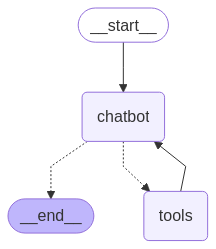

In [9]:
# 此示例有问题的，和别的mcp服务端的工具，无法直接使用；


# 先创建llm
import os
from langchain.chat_models import init_chat_model

API_KEY = "sk-123"

BASE_URL = "https://api.deepseek.com"

os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL


llm = init_chat_model("openai:deepseek-chat")


# 获取mcp
from langchain_mcp_adapters.client import MultiServerMCPClient

mcp_servers={
       "howtocook-mcp": {
        "url": "https://mcp.api-inference.modelscope.cn/sse/0834c80993e34a",
        "transport": "sse"
         }
}
default_tools=[]
enabled_tools = {}

client=MultiServerMCPClient(mcp_servers)

loaded_tools = default_tools[:]
for tool in await  client.get_tools():
    print(tool.name)
    # if tool.name in enabled_tools:
    tool.description = (
        f"Powered by '{tool.name}'.\n{tool.description}"
    )
    loaded_tools.append(tool)
                    
print(loaded_tools)



# mcp_tools = await client.get_tools()

print(loaded_tools)

# 构建一个agent

from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# tool = TavilySearch(max_results=2)


tools = loaded_tools
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass






In [10]:
#与您的聊天机器人互动


config = {"configurable": {"thread_id": "1"}}


user_input = "一个人，晚上吃什么呢，推荐几个菜单给我."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()
    

================================ Human Message =================================

一个人，晚上吃什么呢，推荐几个菜单给我.
================================== Ai Message ==================================
Tool Calls:
  mcp_howtocook_whatToEat (call_0_2441726e-79ee-4dd7-8650-cfe92d3425ef)
 Call ID: call_0_2441726e-79ee-4dd7-8650-cfe92d3425ef
  Args:
    peopleCount: 1
================================= Tool Message =================================
Name: mcp_howtocook_whatToEat

Error: NotImplementedError('StructuredTool does not support sync invocation.')
 Please fix your mistakes.
================================== Ai Message ==================================

我似乎遇到了一些技术问题，无法直接为您推荐菜单。不过，我可以手动为您推荐一些适合一个人晚餐的菜品：

1. **番茄炒蛋** - 简单易做，营养丰富。
2. **青椒土豆丝** - 清爽可口，适合搭配米饭。
3. **蒜蓉西兰花** - 健康低脂，富含维生素。
4. **煎鸡胸肉** - 高蛋白，适合健身人士。
5. **紫菜蛋花汤** - 快速又暖胃。

如果您有其他需求或偏好，可以告诉我，我会进一步调整推荐！


In [27]:
# 先创建llm
import os
from langchain.chat_models import init_chat_model

API_KEY = "sk-123"

BASE_URL = "https://api.deepseek.com"

os.environ["OPENAI_API_KEY"] = API_KEY
os.environ["OPENAI_API_BASE"] = BASE_URL


llm = init_chat_model("openai:deepseek-chat")



from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent

client = MultiServerMCPClient(
    {
        "bing-cn-mcp-server": {
            # make sure you start your weather server on port 8000
            "url": "https://mcp.api-inference.modelscope.cn/sse/3a7bdd8299e141",
            "transport": "sse",
        }
    }
)
tools = await client.get_tools()
print(tools)



agent = create_react_agent(llm, tools)

# bing_response = await agent.ainvoke({"messages": "小米发布的芯片叫什么?"})

bing_response=agent.stream({"messages": "小米发布的芯片叫什么?"}, stream_mode="updates")
for chunk in bing_response:
    print(chunk)


[StructuredTool(name='bing_search', description='使用必应搜索指定的关键词，并返回搜索结果列表，包括标题、链接、摘要和ID', args_schema={'type': 'object', 'properties': {'query': {'type': 'string', 'description': '搜索关键词'}, 'num_results': {'type': 'number', 'default': 5, 'description': '返回的结果数量，默认为5'}}, 'required': ['query'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002D3EE827880>), StructuredTool(name='fetch_webpage', description='根据提供的ID获取对应网页的内容', args_schema={'type': 'object', 'properties': {'result_id': {'type': 'string', 'description': '从bing_search返回的结果ID'}}, 'required': ['result_id'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002D3EE826700>)]
{'agent': {'messages': [AIMessage(content='',

In [ ]:

# New usage: 0.1.0以上的版本

from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent


client = MultiServerMCPClient(
    {
        "bing-cn-mcp-server": {
            "url": "https://mcp.api-inference.modelscope.cn/sse/3a7bdd8299e141",
            "transport": "sse",
        }
    }
)

tools = await client.get_tools()
print(tools)


[StructuredTool(name='bing_search', description='使用必应搜索指定的关键词，并返回搜索结果列表，包括标题、链接、摘要和ID', args_schema={'type': 'object', 'properties': {'query': {'type': 'string', 'description': '搜索关键词'}, 'num_results': {'type': 'number', 'default': 5, 'description': '返回的结果数量，默认为5'}}, 'required': ['query'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002D3EE83A840>), StructuredTool(name='fetch_webpage', description='根据提供的ID获取对应网页的内容', args_schema={'type': 'object', 'properties': {'result_id': {'type': 'string', 'description': '从bing_search返回的结果ID'}}, 'required': ['result_id'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002D3EE83BE20>)]


In [34]:

# open a session explicitly:

from langchain_mcp_adapters.client import MultiServerMCPClient
from langchain_mcp_adapters.tools import load_mcp_tools

client = MultiServerMCPClient(
    {
        "bing-cn-mcp-server": {
            "url": "https://mcp.api-inference.modelscope.cn/sse/3a7bdd8299e141",
            "transport": "sse",
        }
    }
)
async with client.session("bing-cn-mcp-server") as session:
    tools = await load_mcp_tools(session)

    print(tools)

    agent = create_react_agent(llm, tools)

    # bing_response = await agent.ainvoke({"messages": "小米发布的芯片叫什么?"})

    bing_response=agent.stream({"messages": "小米发布的芯片叫什么?"}, stream_mode="updates")
    for chunk in bing_response:
        print(chunk)


[StructuredTool(name='bing_search', description='使用必应搜索指定的关键词，并返回搜索结果列表，包括标题、链接、摘要和ID', args_schema={'type': 'object', 'properties': {'query': {'type': 'string', 'description': '搜索关键词'}, 'num_results': {'type': 'number', 'default': 5, 'description': '返回的结果数量，默认为5'}}, 'required': ['query'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002D3EEA81620>), StructuredTool(name='fetch_webpage', description='根据提供的ID获取对应网页的内容', args_schema={'type': 'object', 'properties': {'result_id': {'type': 'string', 'description': '从bing_search返回的结果ID'}}, 'required': ['result_id'], 'additionalProperties': False, '$schema': 'http://json-schema.org/draft-07/schema#'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x000002D3EEA81DA0>)]
{'agent': {'messages': [AIMessage(content='',

In [35]:
import asyncio
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, StateGraph
from langgraph.constants import START, END
from langchain_openai import ChatOpenAI


model = ChatOpenAI(model="gpt-4o")

class ComplicatedState(MessagesState):
    new_field: str

async def make_graph():
    client = MultiServerMCPClient(
        {
            "weather": {
                "url": "http://localhost:8000/sse",
                "transport": "sse",
            }
        }
    )
    # since get_tools is not an async, it could be called directly
    tools = await client.get_tools()

    sub_graph_workflow = StateGraph(ComplicatedState)
    sub_graph_workflow.add_node("executor", create_react_agent(model, tools))
    sub_graph_workflow.add_edge(START, "executor")
    sub_graph_workflow.add_edge("executor", END)
    sub_graph = sub_graph_workflow.compile()

    def call_sub_graph(state: MessagesState):
        # this is just a demonstration, the graph could be larger
        # there will be more invoke and more def instead of async def
        return sub_graph.invoke(ComplicatedState(messages=state["messages"], new_field="something"))

    main_graph_workflow = StateGraph(MessagesState)
    main_graph_workflow.add_node("sub_graph", call_sub_graph)
    main_graph_workflow.add_edge(START, "sub_graph")
    main_graph_workflow.add_edge("sub_graph", END)
    main_graph = main_graph_workflow.compile()

    return main_graph

async def main():
    graph = await make_graph() # top level async here
    result = await graph.ainvoke({"messages": "What is the weather like in New York?"}) # it seems ainvoke is necessary for the later tool invocation
    print(result)

# Change the transport to 'sse' and start the mcp server first:
# https://github.com/modelcontextprotocol/quickstart-resources/tree/main/weather-server-python

if __name__ == "__main__":
    asyncio.run(main())


RuntimeError: asyncio.run() cannot be called from a running event loop